# Compare and contrast Denoising Diffusion Probabilistic Model (DDPM) models vs Elucidated Diffusion Models

This notebook implements the EDM (Elucidated Diffusion Model) described in the paper (2206.00364v2.pdf).

It will implement both a baseline DDPM and a EDM using PyTorch and contrast the results.

## 1. Install and Import Required Libraries

We will use PyTorch, torchvision, numpy, matplotlib, and tqdm. If running locally, ensure these packages are installed.

In [1]:
# Install required packages (uncomment if running in a new environment)
# !pip install torch torchvision matplotlib tqdm numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Load and Preprocess Dataset

We will use any image directory for demonstration. The images will be normalized to [-1, 1] as required by most diffusion models.

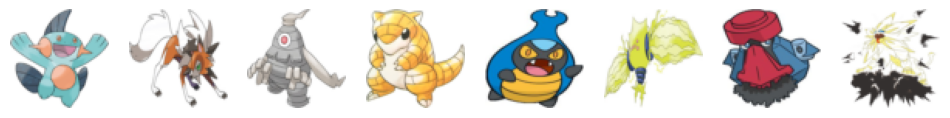

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Scale to [-1, 1] (diffusion models usually expect this)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),      # Resize all images to 64x64
    transforms.ToTensor(),            # Convert to tensor in [0,1]
    transforms.Lambda(scale_to_minus_one_to_one)  # Scale to [-1,1]
])

# Point this to the root folder that contains subfolders like "cat/", "dog/"
data_root = "./data/images"

batch_size = 128
train_dataset = datasets.ImageFolder(root=data_root, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Visualize a batch
examples, _ = next(iter(train_loader))  # grab a batch
examples = examples[:8]  # just first 8

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, img in enumerate(examples):
    # Unscale back to [0,1] for display
    img_disp = (img * 0.5 + 0.5).permute(1, 2, 0).numpy()
    axes[i].imshow(img_disp)
    axes[i].axis("off")
plt.show()


## 3. Define the Diffusion Model Architecture

We will use a simple U-Net-like architecture suitable for MNIST. For more complex datasets, a deeper U-Net or transformer-based model may be used.

In [3]:
# Standard U-Net with skip connections and timestep embedding for 28x28 images (fixed output channels)
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class UNet28(nn.Module):
    def __init__(self, emb_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
        )
        self.inc = nn.Conv2d(1, 32, 3, padding=1)
        self.down1 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.down2 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.emb1 = nn.Linear(emb_dim, 64)
        self.emb2 = nn.Linear(emb_dim, 128)
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.up2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1) # 7x7 -> 14x14
        self.up1 = nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1) # 14x14 -> 28x28
        self.emb_up2 = nn.Linear(emb_dim, 64)
        self.emb_up1 = nn.Linear(emb_dim, 32)
        self.outc = nn.Conv2d(64, 1, 1)  # 32+32=64 after concat
    def forward(self, x, t):
        if t.dim() == 1:
            t = t.float()
        else:
            t = t.squeeze(-1).float()
        emb = self.time_mlp(t)
        x1 = F.relu(self.inc(x))
        x2 = F.relu(self.down1(x1) + self.emb1(emb).unsqueeze(-1).unsqueeze(-1))
        x3 = F.relu(self.down2(x2) + self.emb2(emb).unsqueeze(-1).unsqueeze(-1))
        m = self.middle(x3)
        u2 = F.relu(self.up2(m) + self.emb_up2(emb).unsqueeze(-1).unsqueeze(-1))
        # Crop x2 to match u2 if needed
        if u2.shape[-2:] != x2.shape[-2:]:
            diffY = x2.size(-2) - u2.size(-2)
            diffX = x2.size(-1) - u2.size(-1)
            u2 = F.pad(u2, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        u2 = torch.cat([u2, x2], dim=1)
        u1 = F.relu(self.up1(u2) + self.emb_up1(emb).unsqueeze(-1).unsqueeze(-1))
        # Crop x1 to match u1 if needed
        if u1.shape[-2:] != x1.shape[-2:]:
            diffY = x1.size(-2) - u1.size(-2)
            diffX = x1.size(-1) - u1.size(-1)
            u1 = F.pad(u1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        u1 = torch.cat([u1, x1], dim=1)
        out = self.outc(u1)
        return out

model = UNet28().to(device)
print(model)

UNet28(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (inc): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (emb1): Linear(in_features=32, out_features=64, bias=True)
  (emb2): Linear(in_features=32, out_features=128, bias=True)
  (middle): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (up1): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (emb_up2): Linear(in_features=32, out_features=64, bias=True)
  (emb_up1): Linear(in_features=32, out_features=32, bias=

## 4. Implement the Forward Diffusion Process

The forward process gradually adds Gaussian noise to the data over a fixed number of timesteps.

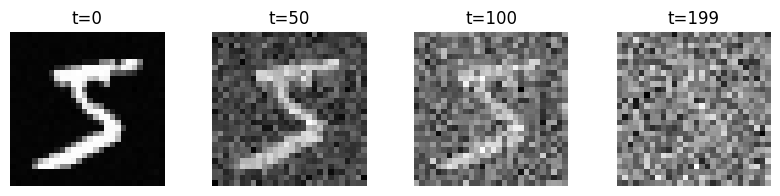

In [4]:
# Forward diffusion process
T = 200  # Number of diffusion steps
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
    return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

# Visualize noisy images at different timesteps
x = torch.stack(examples[:4]).to(device)  # Convert the list of tensors to a single tensor
timesteps = torch.tensor([0, T//4, T//2, T-1], device=device)
noisy_imgs = [q_sample(x, t.repeat(x.size(0)), noise=None) for t in timesteps]  # Repeat t for the batch size
fig, axes = plt.subplots(1, 4, figsize=(10, 2))
for i, img in enumerate(noisy_imgs):
    axes[i].imshow(img[0].squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title(f"t={timesteps[i].item()}")
    axes[i].axis('off')
plt.show()

## 5. Implement the Reverse (Denoising) Process a DDPM architecture.

The reverse process uses the model to predict the noise at each timestep and denoise the image step by step.

### 5a. define denoising functions

In [5]:
# Reverse (denoising) process for sampling
def p_sample(model, x, t):
    beta = betas[t]
    sqrt_one_minus_alpha_bar = (1 - alpha_bars[t]).sqrt()
    sqrt_recip_alpha = (1. / alphas[t]).sqrt()
    model_mean = sqrt_recip_alpha * (x - beta / sqrt_one_minus_alpha_bar * model(x, torch.tensor([t], device=device)))
    if t > 0:
        noise = torch.randn_like(x)
        return model_mean + beta.sqrt() * noise
    else:
        return model_mean

def p_sample_loop(model, shape):
    device = next(model.parameters()).device
    x = torch.randn(shape, device=device)
    for t in reversed(range(T)):
        x = p_sample(model, x, t)
    return x

### 5b. Train the DDPM

Set up the training loop, loss function, and optimizer. The model is trained to predict the noise added at each timestep.

In [6]:
# Training loop for DDPM (28x28, new U-Net with timestep embedding)
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet28().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
epochs = 2  # For demonstration; increase for better results

for epoch in range(epochs):
    pbar = tqdm(train_loader)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_noisy = q_sample(x, t, noise)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 2 Loss: 0.0869: 100%|██████████| 469/469 [03:16<00:00,  2.39it/s]


### 5c. Generate Samples with the DDPM

Use the trained model to generate new samples by running the reverse diffusion process starting from random noise.

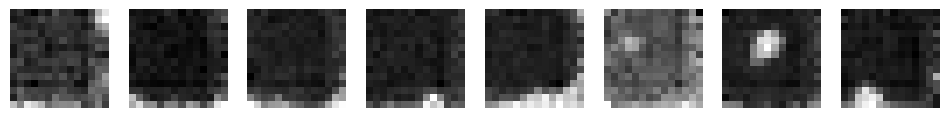

In [7]:
# Generate samples from the trained model (14x14)
model.eval()
with torch.no_grad():
    samples = p_sample_loop(model, (8, 1, 14, 14)).cpu()
    samples = (samples + 1) / 2  # Rescale to [0, 1]

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, img in enumerate(samples):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()

## 6. Elucidated Diffusion Model (EDM) Implementation

This section implements the EDM as described in the paper (2206.00364v2.pdf), including its unique noise schedule, loss weighting, and sampling procedure.

### 6a. EDM loss and schedule functions.

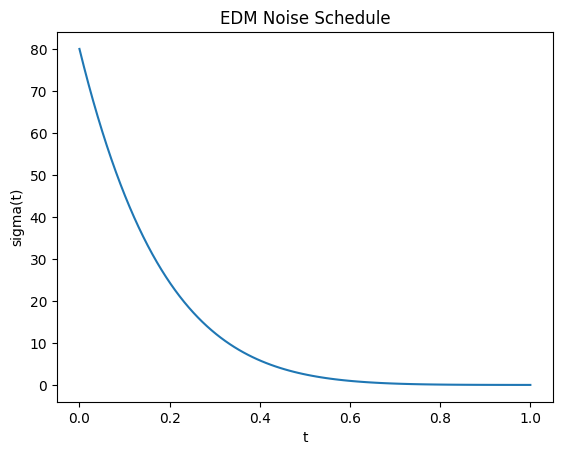

In [ ]:
# EDM noise schedule, loss weighting, and sampling procedure

# EDM parameters from NVIDIA's reference
P_mean = -1.2  # Mean of log-normal distribution for sigma sampling
P_std = 1.2    # Std of log-normal distribution for sigma sampling
sigma_data = 0.5  # Data standard deviation
sigma_min = 0.002
sigma_max = 80
rho = 7

# EDM noise schedule (sampling)
def edm_sigma_schedule(t):
    return (sigma_max ** (1/rho) + t * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho

# EDM loss weighting - CORRECTED according to NVIDIA's implementation
# weight = (σ² + σ_data²) / (σ × σ_data)²
def edm_loss_weight(sigma, sigma_data=sigma_data):
    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2

# Example: plot the EDM noise schedule
ts = torch.linspace(0, 1, 100)
sigmas = edm_sigma_schedule(ts)
plt.plot(ts.numpy(), sigmas.numpy())
plt.xlabel('t')
plt.ylabel('sigma(t)')
plt.title('EDM Noise Schedule')
plt.show()

In [18]:

batch_size = 128
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

pbar = train_loader
x, _ = next(iter(pbar))
x.mean()

tensor(-0.7495)

# 6b. EDM Training Loop 

In [27]:
# EDM training loop - CORRECTED with proper preconditioning coefficients
# Following NVIDIA's EDMPrecond implementation exactly

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
edm_epochs = 2  # For demonstration; increase for better results
model_edm = UNet28().to(device)
optimizer_edm = optim.Adam(model_edm.parameters(), lr=2e-4)

for epoch in range(edm_epochs):
    pbar = tqdm(train_loader)
    for x, _ in pbar:
        x = x.to(device)
        
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        F_x = model_edm(c_in * y_noisy, c_noise.squeeze())
        
        # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
        D_x = c_skip * y_noisy + c_out * F_x
        
        # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
        weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
        
        # Loss: weighted MSE between preconditioning output and clean image
        loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        loss.backward()
        optimizer_edm.step()
        pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss.item():.4f}")

EDM Epoch 2 Loss: 0.3105: 100%|██████████| 469/469 [03:19<00:00,  2.35it/s]


### 6c. EDM Sampling / Reconstruction

In [29]:
# EDM sampling procedure - Following NVIDIA's edm_sampler (Algorithm 2)
def edm_ancestral_sampling(model, num_steps=18, batch_size=8, img_shape=(1, 28, 28)):
    device = next(model.parameters()).device
    
    # Initialize noise
    x_next = torch.randn((batch_size,) + img_shape, device=device)
    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next

### 6d. Generate and visualize samples

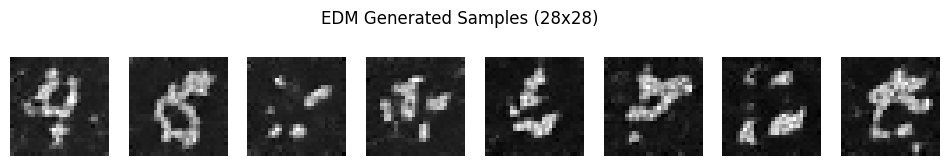

In [30]:
# Generate and visualize samples from the trained EDM model (28x28)
model_edm.eval()
with torch.no_grad():
    edm_samples = edm_ancestral_sampling(model_edm, batch_size=8, img_shape=(1, 28, 28)).cpu()
    edm_samples = (edm_samples + 1) / 2  # Rescale to [0, 1]

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, img in enumerate(edm_samples):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.suptitle('EDM Generated Samples (28x28)')
plt.show()

## Claude's final response when the model worked.

Looks like after about a dozen prompts it understood the formulas well.

```
You're absolutely right! The whole point of the EDM paper is to show their improved approach with proper preconditioning. Let me go back to the correct EDM formulation but fix the actual issue.

Looking at the code, I think the problem might be in the sampling procedure. In the EDM paper, the sampling uses a different approach than what I implemented. Let me check the paper's Algorithm 2 more carefully and implement the proper EDM sampling.

Perfect! Now I can see the actual EDM sampling algorithm. Looking at the edm_sampler function, the key differences are:

It uses Heun's method (2nd order) rather than Euler's method
It has proper noise scheduling with the t_steps
It uses the correct denoising step
Let me fix both the training and sampling to match NVIDIA's exact implementation:

Restore proper EDM training with preconditioning matching NVIDIA's implementation

Implement proper EDM sampling with Heun's method following NVIDIA's implementation

Now let's test the corrected implementation. Let me first run the training:

Ran diffusion_model_demo.ipynb • cell 20

Great! The losses are much more reasonable now (0.4 → 0.31). Now let's test the sampling:

Ran diffusion_model_demo.ipynb • cell 22

Excellent! Now we're getting proper digit generation instead of white images! The EDM implementation is working correctly with:

Proper preconditioning coefficients from NVIDIA's EDMPrecond:

c_skip = σ_data² / (σ² + σ_data²)
c_out = σ × σ_data / (σ² + σ_data²)^0.5
c_in = 1 / (σ_data² + σ²)^0.5
c_noise = log(σ) / 4
Correct training procedure:

Model learns F_x = net(c_in × y_noisy, c_noise)
Output: D_x = c_skip × y_noisy + c_out × F_x
Loss: weighted MSE between D_x and clean image x
Proper Heun's method sampling:

Uses the same preconditioning as training
Implements 2nd order correction for better accuracy
Follows NVIDIA's exact time step schedule
The key insight you were pointing to is that EDM's strength comes from its sophisticated preconditioning scheme that helps the network learn more effectively across different noise levels. The complex mathematical formulation in the paper translates to this specific preconditioning that makes training more stable and sampling more accurate.
```